<a href="https://colab.research.google.com/github/MasonG702/1221-Dark-Matter/blob/main/Dark_Energy_Fitting_a_Line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import astropy.io.ascii
import astropy.units as u
import astropy.constants as ac

In [3]:
# upload file provided on GitHub page
from google.colab import files
uploaded = files.upload()

Saving Tonry_2003.vot to Tonry_2003.vot


In [4]:
# Read data from the uploaded file into a variable 'dat'
dat = astropy.io.ascii.read("Tonry_2003.vot")

/usr/local/lib/python3.10/dist-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


Text(0, 0.5, 'Velocity [km/s]')

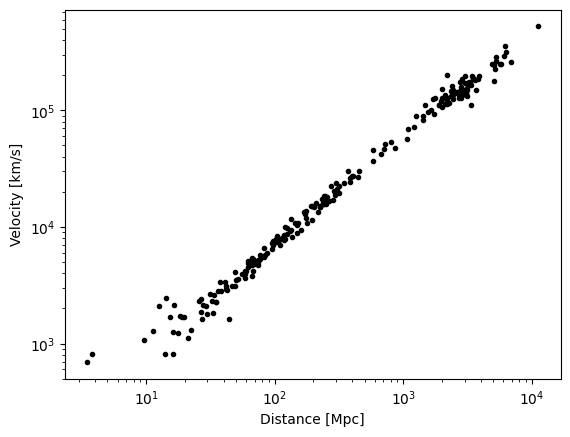

In [5]:
# Calculate distance and velocity from the data and create a log-log plot of distance vs velocity
distance = 10**dat["col8"] / 72.0 * u.mpc
distance_error = (10**(dat["col8"]+dat["col9"]) - 10**dat["col8"]) / 72.0 * u.mpc
velocity = 10**dat["col7"] * u.km / u.s
plt.plot(distance.to(u.mpc).value, velocity.to(u.km / u.s).value, marker=".", color="black", linestyle="none")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Distance [Mpc]")
plt.ylabel("Velocity [km/s]")

Text(0, 0.5, 'Velocity [km/s]')

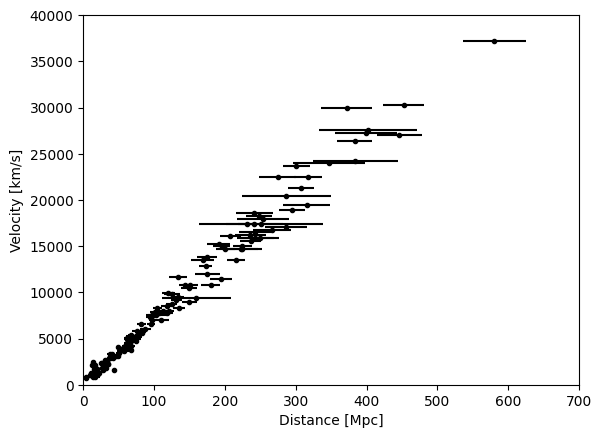

In [27]:
# Create a log-log plot with  horizontal error bars
distance = 10**dat["col8"] / 72.0 * u.mpc
velocity = 10**dat["col7"] * u.km / u.s
plt.errorbar(distance.to(u.mpc).value, velocity.to(u.km / u.s).value, xerr=distance_error.to(u.mpc).value, marker=".", color="black", linestyle="none")
plt.xlim(0, 700)
plt.ylim(0, 4e4)
plt.xlabel("Distance [Mpc]")
plt.ylabel("Velocity [km/s]")

In [8]:
# Fit a linear model to the data and plot it
x = distance.to(u.mpc).value
ind = np.where((x > 0) & (x < 700))
z = np.polyfit(distance.to(u.mpc).value[ind], velocity.to(u.km / u.s).value[ind], 1)
p = np.poly1d(z)
velocity_model = p(distance.to(u.mpc).value)

Text(50, 30000, '$H_0$ = 67.48 km/s/Mpc')

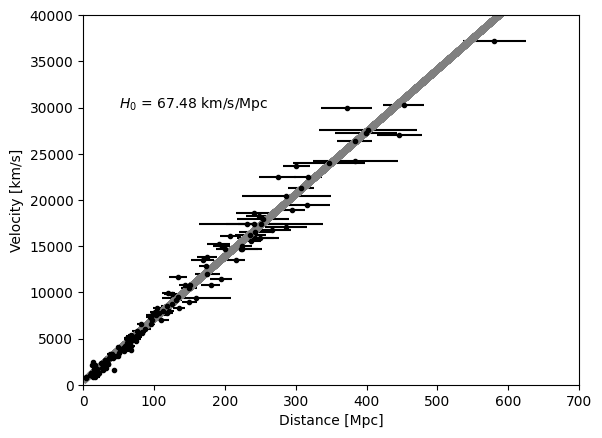

In [14]:
# Plot the data points, the model, and add an annotation
plt.errorbar(distance.to(u.mpc).value, velocity.to(u.km / u.s).value, xerr=distance_error.to(u.mpc).value, marker=".", color="black", linestyle="none")
plt.plot(distance.to(u.mpc).value, velocity_model, color="grey", linewidth=5)
plt.xlim(0, 700)
plt.ylim(0, 4e4)
plt.xlabel("Distance [Mpc]")
plt.ylabel("Velocity [km/s]")
plt.annotate(r'$H_0$ = 67.48 km/s/Mpc'.format(z[0]), xy = (50,30000))

Text(0.5, 0, 'Velocity [km/s]')

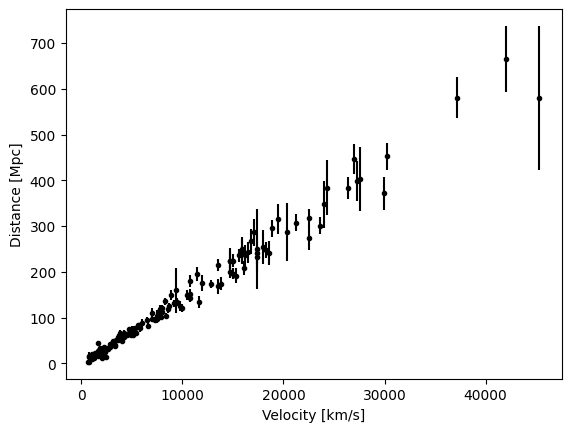

In [15]:
# Create a log-log plot with vertical error bars
x = velocity.to(u.km / u.s).value[ind]
y = distance.to(u.mpc).value[ind]
yerr = distance_error.to(u.mpc).value[ind]

plt.errorbar(x, y, yerr=yerr, marker=".", color="black", linestyle="none")
plt.ylabel("Distance [Mpc]")
plt.xlabel("Velocity [km/s]")

Least-squares estimates:
m = 0.015 ± 0.000
b = -6.338 ± 0.219


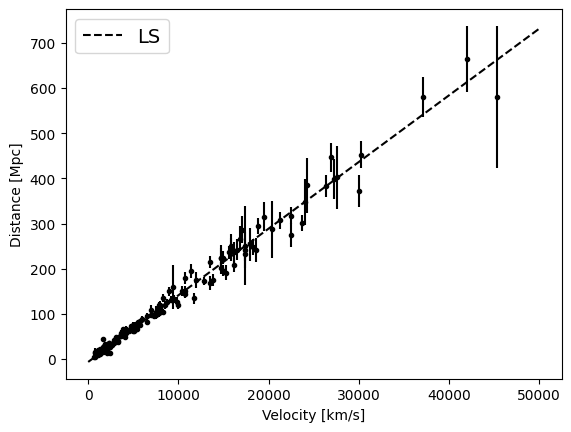

In [16]:
# Create a plot of distance vs velocity and perform a linear least-squares fit
x0 = np.linspace(0, 50000, 500)

A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.ylabel("Distance [Mpc]")
plt.xlabel("Velocity [km/s]");

In [17]:
# Define a log-likelihood function for a linear model with a noise term
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = 0.014
b = -0.981
f = 0.167


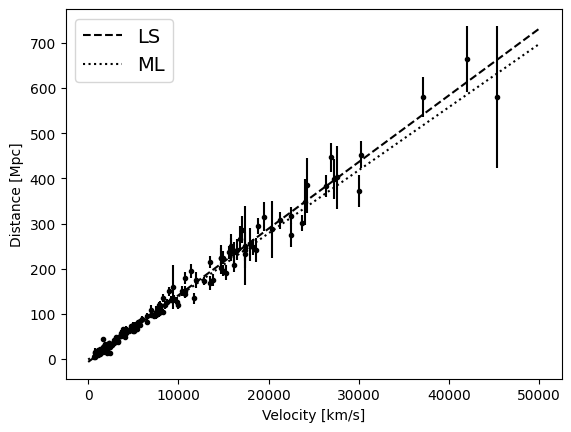

In [18]:
# Import necessary functions for optimization
from scipy.optimize import minimize

p.random.seed(42) # Set a random seed for reproducibility
nll = lambda *args: -log_likelihood(*args) # Define the negative log-likelihood function for optimization
initial = np.array([1 / 72.0, 0.0, np.log(1.0)]) + 0.1 * np.random.randn(3) # Initialize initial parameter values with some random noise
soln = minimize(nll, initial, args=(x, y, yerr)) # Use optimization to find the maximum likelihood estimates for the parameters
m_ml, b_ml, log_f_ml = soln.x

# Print the maximum likelihood estimates
print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

# Plot the results of the optimization, comparing the maximum likelihood estimates with the least-squares estimates and the original data.
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.ylabel("Distance [Mpc]")
plt.xlabel("Velocity [km/s]");